In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [61]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [62]:
OB = 'OB2'

In [63]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 4000) & (x[:,0] < 22500)

exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (~((x[:,0] > 10000) & (x[:,0] < 11500))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

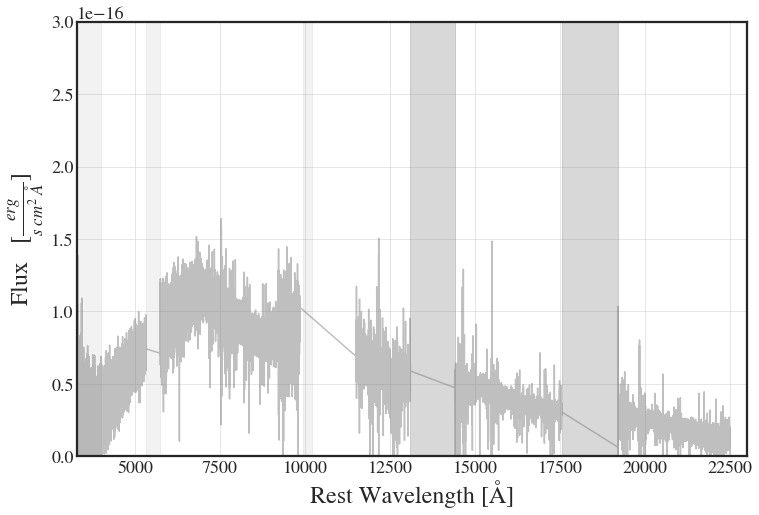

In [64]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [65]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [66]:
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, tau2 = 0.1, lam2=7000): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)

    pcyg_prof_novel = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)

    
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1

    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction*pcyg_prof_novel
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    tau2, lam2 = v["tau2"], v["lam2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, tau2=tau2, lam2=lam2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

In [67]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [52]:
#p = lmfit.Parameters()
#OB = 'OB2'
#with open("./data/%s_init.json"%OB, 'r') as infile:
#    p.load(infile)

pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=2.42), p['ve'], p['vphot'])
    
#p['occult'].vary=False; p['occult'].value=1
#p['occult'].vary=False; p['occult'].value=1
p.add('tau2', value=0.1, min=0, max=10)
p.add('lam2', value=9000, min=7000, max=12000)
p
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 
    
start = time.time()
#mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

43.236864507905146 <Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]> <Parameter 'vphot', value=0.24759563525437875 +/- 0.000606, bounds=[0:1]>
Time elapsed: 0.0


In [53]:
p

Parameters([('T', <Parameter 'T', value=3935.619453803755 +/- 2.11, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.752046990957482e-29 +/- 8.11e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24759563525437875 +/- 0.000606, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.27924953077917924 +/- 0.000543, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.7206571723678954 +/- 0.149, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1.4727446008300493 +/- 0.0539, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.1, bounds=[0:10]>), ('lam2', <Parameter 'lam2', value=9000, bounds=[7000:12000]>)])

In [46]:
with open("./data/%s_1.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [47]:
p = lmfit.Parameters()
with open("./Data/%s_1.json"%OB, 'r') as infile:
    p.load(infile)

#p
lum_dist_arr(p['N'],p['vphot'],n_days=2.45), p['ve'], p['vphot']
p['ve'].value = 0.07
## OB2_1 : fixed ve = [0-0.2]
## OB2_2 : free  ve

In [9]:
pickle_in = open("./data/OB2/OB2_3_peaks_100walkers.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=2.43))
#p['ve'].vary = True
p['sig1'].vary=False; p['sig2'].vary=False; 
p['amp1'].min = 0; p['amp2'].min = 0; 
p['amp1'].vary=False; p['amp2'].vary=False; 
p['amp1'].value = 0; p['amp2'].value = 0; 

p

43.21798726760515


Parameters([('T', <Parameter 'T', value=3926.963436417254 +/- 2.27, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.791868985489651e-29 +/- 9.09e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24808001429652052 +/- 0.000521, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.2794726726843779 +/- 0.000576, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.8622936807478554 +/- 0.18, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1.3053866710215676 +/- 0.0509, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.03e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=1.1051714360873893e-07 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=7.189609207585115e-08 (fixed), bounds=[1e-08:3e-07]>)])

In [59]:
pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['cen1'].vary=True; p['cen2'].vary=True; 

p

Parameters([('T', <Parameter 'T', value=3934.8594459404258 +/- 7.23, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.7550329862747807e-29 +/- 3.01e-31, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24781409280561079 +/- 0.00176, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.27939923960610835 +/- 0.000781, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.8163532086079675 +/- 0.251, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.774809458787137 +/- 0.179, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1.466828834576058 +/- 0.0625, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.7278762857659176 +/- 0.0639, bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7684222625617488 +/- 0.0241, bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189493946839334e-06 +/- 1.77e-09, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.900461865543837e-06 +/- 1.72e-09, bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.726743213315782e-08 +/- 3.84e-09, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.255259989160374e-07 +/- 5.4e-09, bounds=[1e-08:3e-07]>)])

In [9]:
pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

#p['sig1'].value = 0.55e-7; p['sig2'].value = 1.10e-7; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].min = 0; p['amp2'].min = 0; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['cen1'].vary=False; p['cen2'].vary=False; 
p['cen2'].min = 1.7e-6
#p['amp1'].value = 0.0; p['amp2'].value = 0.0;
#p['cen2'].value=2.03e-6; p['sig2'].value=7.2e-8; 
p['occult'].vary=False; p['occult'].value=1

p

Parameters([('T', <Parameter 'T', value=3935.619453803755 +/- 2.11, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.752046990957482e-29 +/- 8.11e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24759563525437875 +/- 0.000606, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.27924953077917924 +/- 0.000543, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.7206571723678954 +/- 0.149, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1 (fixed), bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 +/- 0.0115, bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 +/- 0.0108, bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 +/- 1.45e-09, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 +/- 3.49e-10, bounds=[1.7e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 +/- 1.69e-09, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 +/- 1.53e-09, bounds=[1e-08:3e-07]>)])

In [20]:
p

Parameters([('T', <Parameter 'T', value=3935.619453803755 +/- 2.11, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.752046990957482e-29 +/- 8.11e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24759563525437875 +/- 0.000606, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.27924953077917924 +/- 0.000543, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.7206571723678954 +/- 0.149, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1.4727446008300493 +/- 0.0539, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.1, bounds=[0:10]>), ('lam2', <Parameter 'lam2', value=9000, bounds=[7000:12000]>)])

In [123]:
pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p.add('tau2', value=0.1, min=0, max=100)
p.add('lam2', value=9000, min=7000, max=12000)
p['lam2'].vary=False
p
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 
p

Parameters([('T', <Parameter 'T', value=3935.619453803755 +/- 2.11, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.752046990957482e-29 +/- 8.11e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24759563525437875 +/- 0.000606, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.27924953077917924 +/- 0.000543, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.7206571723678954 +/- 0.149, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1.4727446008300493 +/- 0.0539, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.1, bounds=[0:100]>), ('lam2', <Parameter 'lam2', value=9000 (fixed), bounds=[7000:12000]>)])

In [148]:
#mi_list = []

for i in [11500, 12000]: #[8500, 9000, 9500, 10000, 10500, 11000]: 
    p['lam2'].value=i
    
    start = time.time()
    mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
    end = time.time()
    print('Time elapsed:',(end-start)/60) 
    
    mi_list.append(mi2)

Time elapsed: 0.7967296322186788
Time elapsed: 0.9589811086654663


In [149]:
dl_list = []
lam_list = []
for mi in mi_list: 
    dl = lum_dist_arr( mi.params['N'].value, mi.params['vphot'].value, n_days=2.42 )
    
    dl_list.append(dl)
    lam_list.append(mi.params['lam2'].value)


(40.0, 45.0)

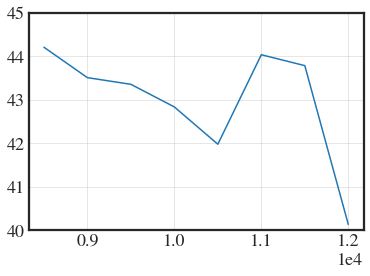

In [150]:
plt.plot(np.array(lam_list), np.array(dl_list))#, color)
plt.ylim(40, 45)


In [134]:
dl_list

[43.35708546816455, 43.35708546816455, 43.35708546816455]

In [132]:
lam_list

[9500, 9500, 9500]

#### Markov Chain Monto Carlo to sample distribution

In [98]:
mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 30 #v = p.valuesdict()
res3 = mini.emcee(nwalkers=nwalkers, burn=0, steps=30, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 30/30 [00:25<00:00,  1.17it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.04479534 3.4440679  2.78318461 3.28291324 3.16044177 3.34011702
 2.98298476 3.18338964]
Time elapsed [hours]: 0.007409962746832106


In [168]:
#mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 20 #v = p.valuesdict()

#res_list = []
lam0 = [9500]#, 9500, 10000, 10500, 11000]
lam0 = [7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9625, 9750, 9875, 10000, 10125, 10250, 
        10375, 10500, 10750, 11000, 11250, 11500]
lam0=[9800]
lam0=[9825]
lam0=[11750]

for i in lam0: 
    p['lam2'].value=i
    mini = lmfit.Minimizer(lnprob, p) 

    print(i)
    res4 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=2, workers = 4)
    res_list.append(res4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 ) 
#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

11750


100%|██████████| 3000/3000 [1:04:37<00:00,  1.29s/it]   


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [ 95.98112171  92.93771783 115.6375925   96.18523815 155.44283865
 187.35733144 295.24013907 167.13273174]
Time elapsed [hours]: 1.0772590445809895


In [117]:
res_list

9500
7500
7750
8000
8250
8500
8750
9000
9250
9625
9750
9875
10000
10125
10250
10375
10500
10750
11000


11250
11500
9800
9825
11750


(Text(0, 0.5, '$d_L$'), Text(0.5, 0, '$\\lambda_2$'))

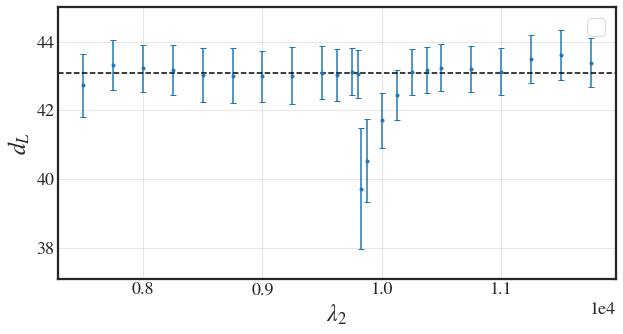

In [169]:
plt.figure(figsize=(10,5))
steady=10000

res_med = []
res_low = []
res_hig = []
lam = []

for res in res_list:
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=2.42 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))
    res_med.append(np.median(dl))
    res_low.append(np.percentile(dl, 15.9))
    res_hig.append(np.percentile(dl, 100-15.9)) 

    lam.append(res.params['lam2'].value)
    
    plt.errorbar(res.params['lam2'].value, np.median(dl), yerr = (np.percentile(dl, 100-15.9)-np.percentile(dl, 15.9))/2, 
                color='C0', capsize=3, fmt='.') 
    
    print(res.params['lam2'].value)
plt.legend(frameon=True, fontsize=22)
#plt.plot(lam, res_med)
#plt.fill_between(lam, res_low, res_hig, alpha=0.2)

plt.ylim(37.1, 45)
plt.axhline(43.1, ls='--', color='k')
plt.ylabel(r'$d_L$'), plt.xlabel(r'$\lambda_2$')

In [170]:
for res in res_list:
    print(res.params['lam2'].value)
    file = "./Data/OB2/4th/lam2_"+str(res.params['lam2'].value)+"_20x3000.pkl"
    with open(file, 'wb') as outfile:
        pickle.dump(res, outfile)

9500
7500
7750
8000
8250
8500
8750
9000
9250
9625
9750
9875
10000
10125
10250
10375
10500
10750
11000
11250
11500
9800
9825
11750


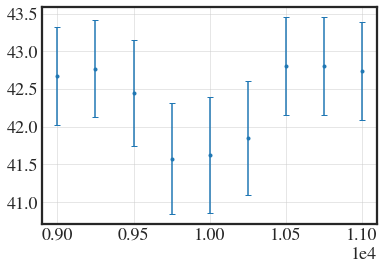

In [122]:
files = ["./Data/OB1/4th/lam2_9000_20x3000.pkl","./Data/OB1/4th/lam2_9250_20x3000.pkl", 
         "./Data/OB1/4th/lam2_9500_20x3000.pkl","./Data/OB1/4th/lam2_9750_20x3000.pkl",
        "./Data/OB1/4th/lam2_10000_20x3000.pkl","./Data/OB1/4th/lam2_10250_20x3000.pkl", 
        "./Data/OB1/4th/lam2_10500_20x3000.pkl","./Data/OB1/4th/lam2_10750_20x3000.pkl",
        "./Data/OB1/4th/lam2_11000_20x3000.pkl"]


for file in files: 
    pickle_in = open(file,"rb")
    res = pickle.load(pickle_in)
    
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=1.43 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))

    plt.errorbar(res.params['lam2'].value, np.median(dl), yerr = (np.percentile(dl, 100-15.9)-np.percentile(dl, 15.9))/2, 
                color='C0', capsize=3, fmt='.') 

42.458797944426436 0.8036017330969025
43.17359294981323 0.6692327396678136
41.62549894884885 0.6478768135636283
43.18710919634542 0.6673043310049029
43.13868552121312 0.671495590290247
43.180425875959806 0.6640608707804949
43.16941526105708 0.6722937017578433


Text(0.5, 0, '$d_L$')

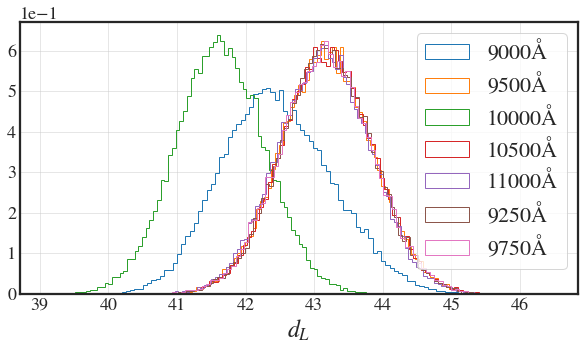

In [79]:
plt.figure(figsize=(10,5))
steady=20000
for res in res_list: 
    #print(np.mean(res.flatchain['vphot']), np.std(res.flatchain['vphot']))
    #plt.hist(res.flatchain['vphot'], bins=100, histtype='step')#, range=(0.25, 0.30))
    
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=2.42 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))
    #plt.scatter(np.arange(len(res.flatchain['vphot'])), res.flatchain['vphot'], alpha=0.1, s=0.1)
    
    #plt.scatter(np.arange(len(res.flatchain['vphot']))[steady:], dl[steady:], alpha=0.1, s=0.1)
    #plt.hist(res.flatchain['vphot'], bins=100, histtype='stepfilled', label=str(res.params['lam2'].value)+'Å', density=True, range=(0.23, 0.26), alpha=0.2)
    
    plt.hist(dl[steady:], bins=100, histtype='step', label=str(res.params['lam2'].value)+'Å', density=True)#, range=(0.25, 0.30))
    print(np.mean(dl[steady:]), np.std(dl[steady:]))
plt.legend(frameon=True, fontsize=22)

plt.xlabel(r'$d_L$')
#plt.xlabel(r'$v_{phot}$')
#plt.xlim(35.5,48)
#plt.savefig('Pictures/add_line_bias_dl_2.png', dpi=300)

In [56]:
res3.params

Parameters([('T', <Parameter 'T', value=3934.2290991225946 +/- 2.33, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.759382611162037e-29 +/- 7.92e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.1794236710403714 +/- 0.0334, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.22273950304691897 +/- 0.0267, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.0220838585376126 +/- 0.382, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.6090342609343129 +/- 0.168, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.12984070735121817 +/- 0.237, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.37851451400121483 +/- 0.187, bounds=[0:10]>), ('lam2', <Parameter 'lam2', value=9362.808784243587 +/- 96.2, bounds=[7000:12000]>)])

43.00757561361582 0.6058565453101716
43.00757561361582 0.6058565453101716


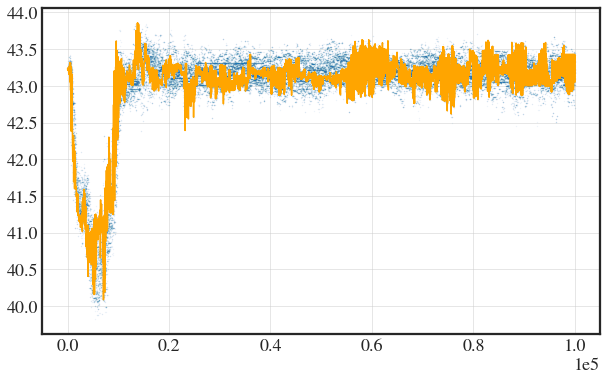

In [119]:
flat = res4.flatchain
#with open("./Data/OB2/OB2_newline_11470.pkl", 'wb') as outfile:
#    pickle.dump(res3, outfile) 
    
plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

print(np.mean(dl), np.std(dl))

#dl = lum_dist_arr(np.array(flat['N'])*np.random.normal(loc=1, scale=0.015, size=len(flat['N'])),
#                      flat['vphot'], n_days=2.42)
print(np.mean(dl), np.std(dl))



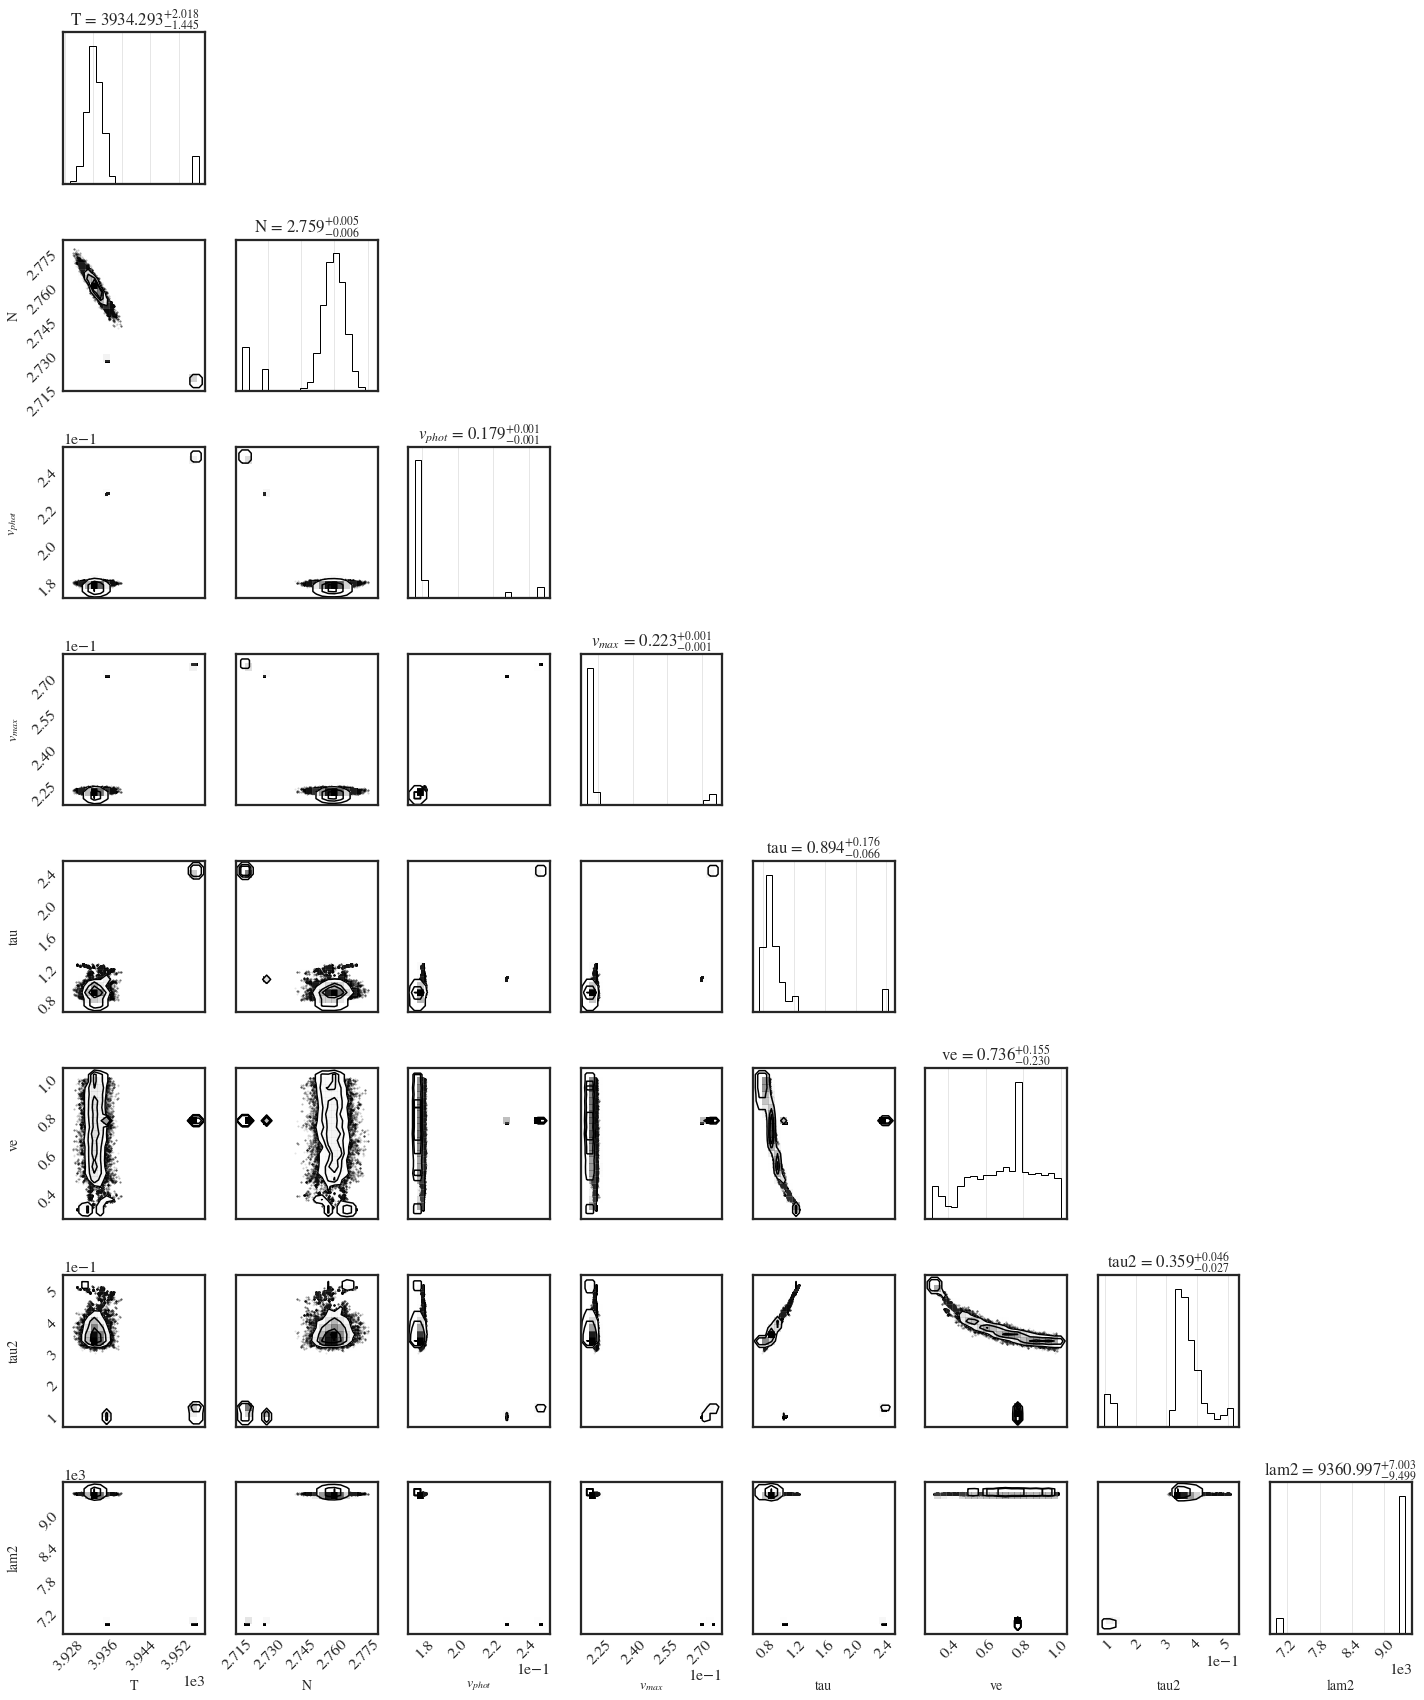

In [59]:
import corner 

n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 100000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['vphot'][rej:], flat['vmax'][rej:], 
                         flat['tau'][rej:], flat['ve'][rej:], flat['tau2'][rej:], flat['lam2'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve', 'tau2', 'lam2'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB2_covariance_newline.png', dpi=300)

43.832875312888724 0.22968587333281015
43.83659793639345 0.40147511764079663


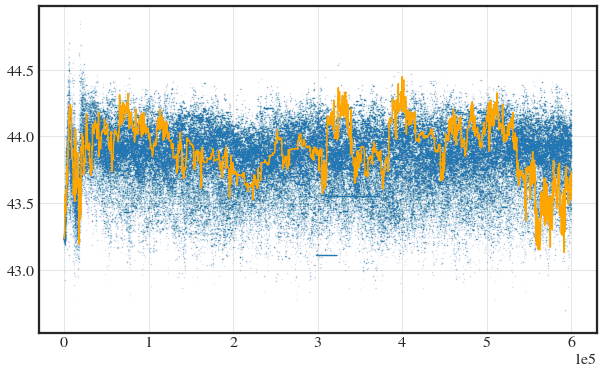

In [48]:
flat = res3.flatchain
#with open("./Data/OB2/OB2_newline_11470.pkl", 'wb') as outfile:
#    pickle.dump(res3, outfile) 
    
plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::50], dl[::50], color='orange')

print(np.mean(dl), np.std(dl))

dl = lum_dist_arr(np.array(flat['N'])*np.random.normal(loc=1, scale=0.015, size=len(flat['N'])),
                      flat['vphot'], n_days=2.42)
print(np.mean(dl), np.std(dl))



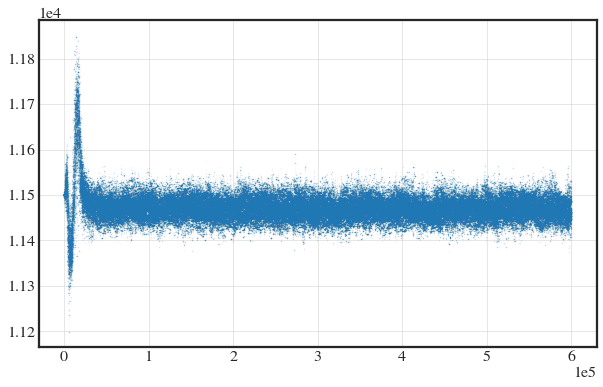

In [43]:
flat = res3.flatchain

plt.figure(figsize=(10,6))
#dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), flat['lam2'], s=0.1, alpha=0.1)
#plt.plot(np.arange(len(dl))[::50], dl[::50], color='orange')

#np.mean(dl), np.std(dl)

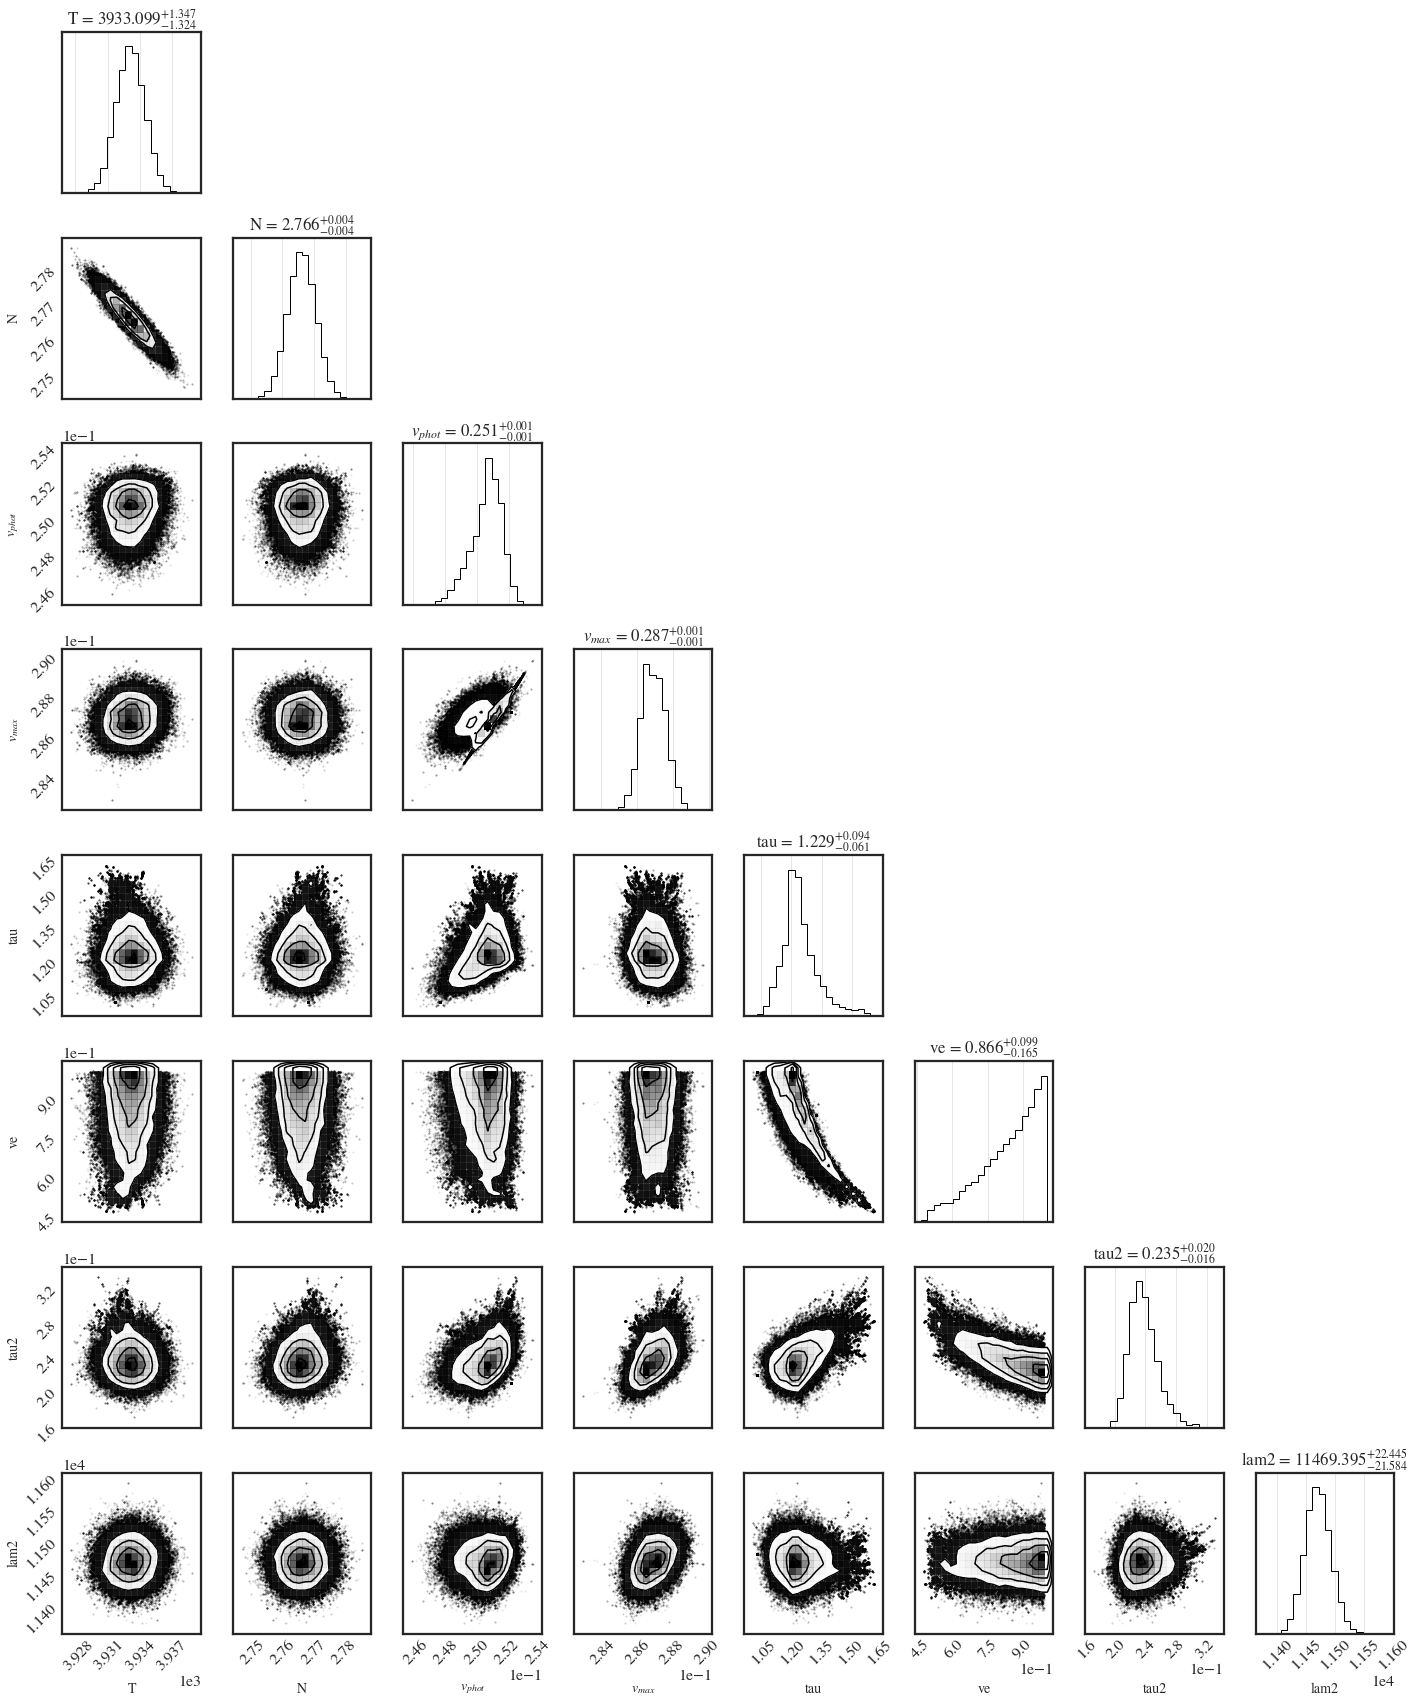

In [46]:
import corner 

n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 100000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['vphot'][rej:], flat['vmax'][rej:], 
                         flat['tau'][rej:], flat['ve'][rej:], flat['tau2'][rej:], flat['lam2'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve', 'tau2', 'lam2'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB2_covariance_newline.png', dpi=300)

In [26]:
res2.params

Parameters([('T', <Parameter 'T', value=3933.9876541823514 +/- 1.49, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.7608510673226104e-29 +/- 5.04e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.17881802815178818 +/- 0.000907, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.22256147019219827 +/- 0.000725, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=0.8533375635185563 +/- 0.0821, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.8141469738256709 +/- 0.158, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.11939712452901496 +/- 0.0283, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.3496473051850093 +/- 0.0296, bounds=[0:10]>), ('lam2', <Parameter 'lam2', value=9362.428824003251 +/- 8.34, bounds=[7000:12000]>)])

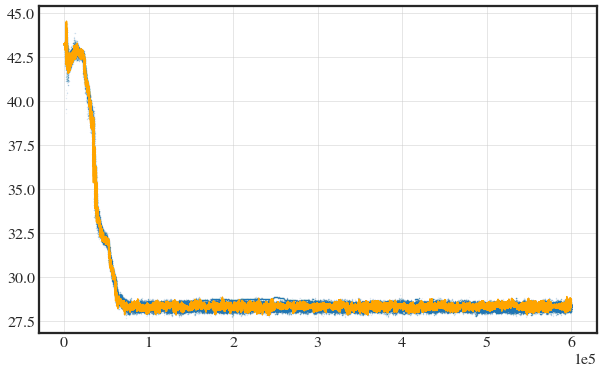

In [49]:
flat = res2.flatchain
#with open("./Data/OB2/OB2_newline_9360.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 
    
plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

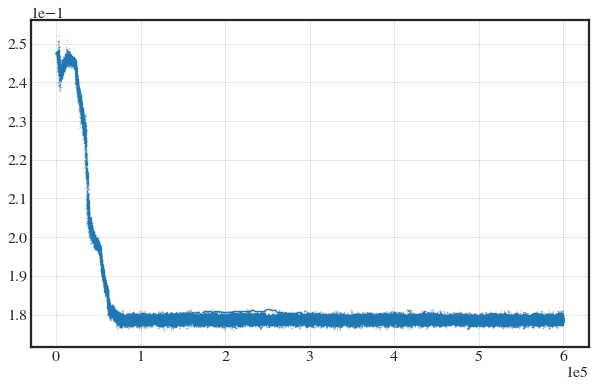

In [31]:
flat = res2.flatchain

plt.figure(figsize=(10,6))
#dl = lum_dist_arr( flat['N'], flat['lam2'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), flat['vphot'], s=0.1, alpha=0.1)
#plt.plot(np.arange(len(dl))[::30], flat['lam2'][::30], color='orange')

In [47]:
res2.params

Parameters([('T', <Parameter 'T', value=3933.9876541823514 +/- 1.49, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.7608510673226104e-29 +/- 5.04e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.17881802815178818 +/- 0.000907, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.22256147019219827 +/- 0.000725, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=0.8533375635185563 +/- 0.0821, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.8141469738256709 +/- 0.158, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.11939712452901496 +/- 0.0283, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.3496473051850093 +/- 0.0296, bounds=[0:10]>), ('lam2', <Parameter 'lam2', value=9362.428824003251 +/- 8.34, bounds=[7000:12000]>)])

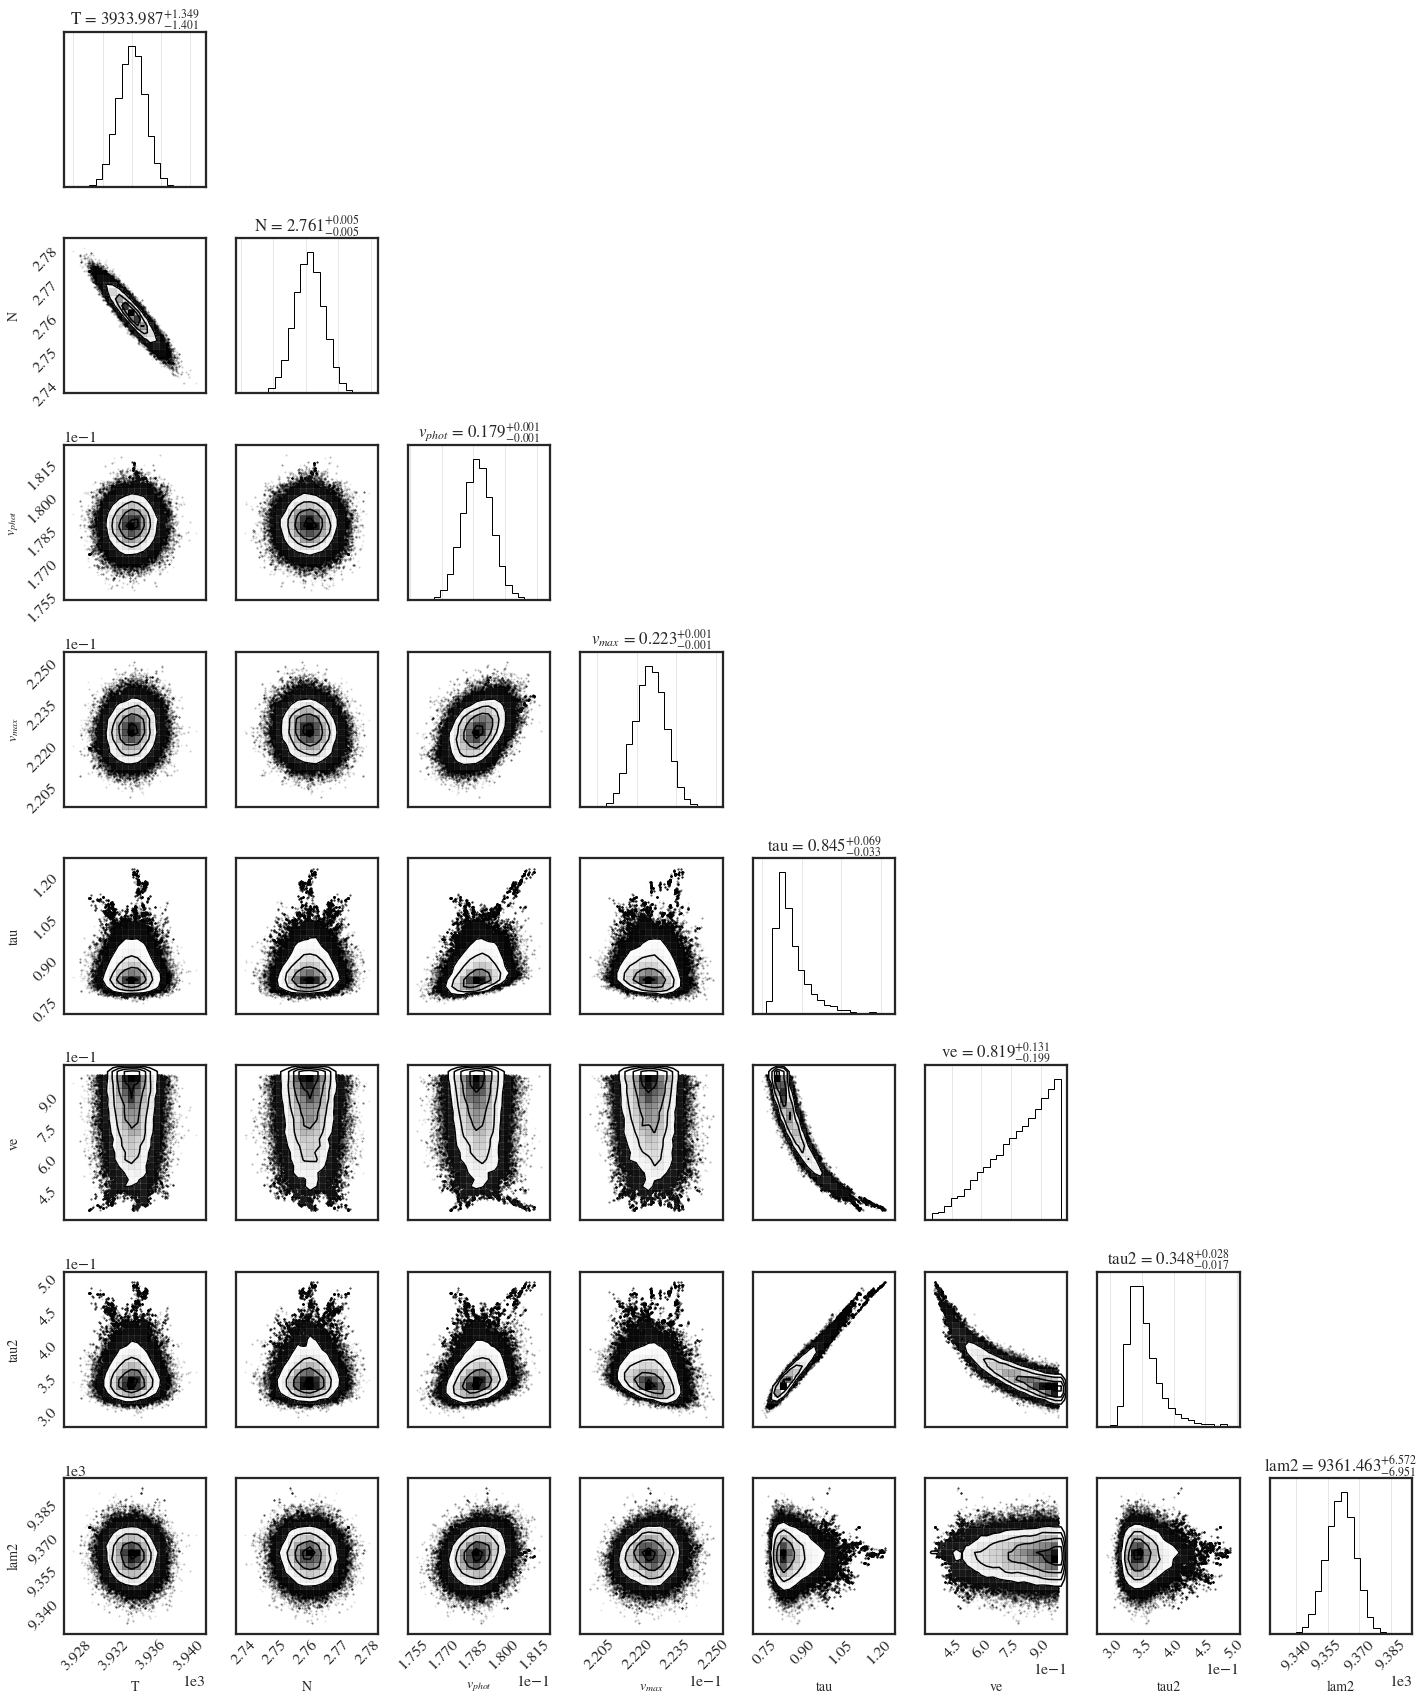

In [29]:
import corner 

n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 100000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['vphot'][rej:], flat['vmax'][rej:], 
                         flat['tau'][rej:], flat['ve'][rej:], flat['tau2'][rej:], flat['lam2'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve', 'tau2', 'lam2'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

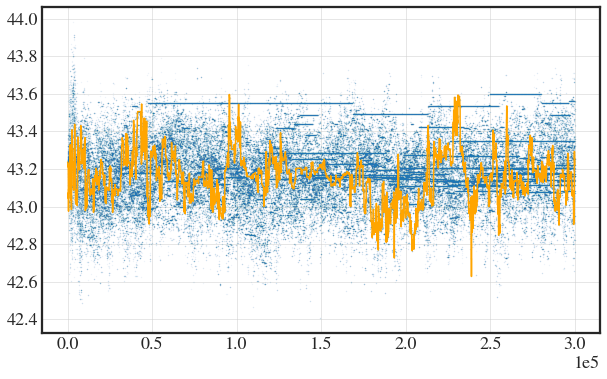

In [14]:
flat = res2.flatchain

plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

In [12]:
with open("./Data/OB2/OB2_lambda_3300_22500_woOccult_woPeak.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 

In [42]:
with open("./Data/OB2/OB2_3_peaks_lambda_13000.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 

In [18]:
#with open("./Data/OB2/OB2_3_peaks_no_gaussian_1.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [14]:
#with open("./Data/OB2/OB2_3_peaks_filtered.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

47.36134005325856 46.744883193855095 48.20082547861604
47.483644074830565 47.01132364526608 48.261646468718624


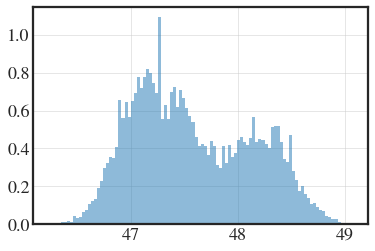

In [69]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
#plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(300*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

array([0.36333333, 0.33285714, 0.34142857, 0.36285714, 0.24285714,
       0.34095238, 0.36857143, 0.36761905, 0.38095238, 0.36809524,
       0.35      , 0.35333333, 0.36333333, 0.3252381 , 0.35619048,
       0.37      , 0.32666667, 0.36095238, 0.36761905, 0.34952381,
       0.35809524, 0.36380952, 0.37619048, 0.39857143, 0.34190476,
       0.3652381 , 0.3747619 , 0.35      , 0.35428571, 0.36428571])

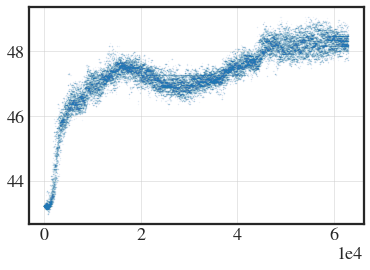

In [70]:
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
res2.acceptance_fraction

38.6844553277932 38.53381547507802 38.82171738157524
38.68877461163725 38.559262622872176 38.81401886133616


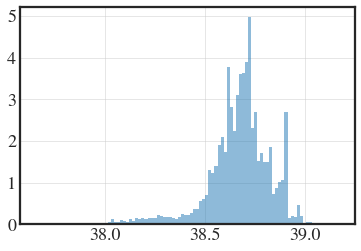

In [11]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
#plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(300*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

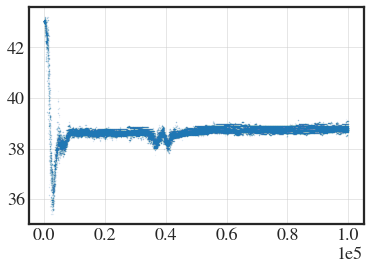

In [13]:
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)

In [9]:
# For loading previous runs... 

pickle_in = open("./data/OB2/OB2_3_peaks_100walkers.pkl","rb")
res2 = pickle.load(pickle_in)
p = res2.params
lum_dist_arr(p['N'],p['vphot'],n_days=2.42), p['ve'], p['vphot']

(43.04013546814999,
 <Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>,
 <Parameter 'vphot', value=0.24808001429652052 +/- 0.000521, bounds=[0:1]>)

In [ ]:
plt.plot( flat['vphot'][::25] ) 


43.04702908840992 42.91479692531522 43.18370582478217
43.04950455676603 42.915496734194825 43.185620432904194


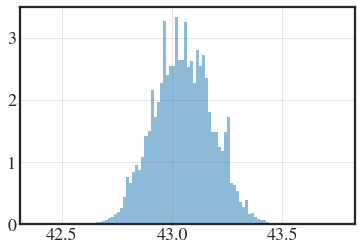

In [18]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
#plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(300*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [18]:
0.00980*c*1e-3/43.6, 0.00980*c*1e-3/43.9

(67.43119266055045, 66.97038724373577)

43.04702908840992 42.91479692531522 43.18370582478217


NameError: name 'nwalkers' is not defined

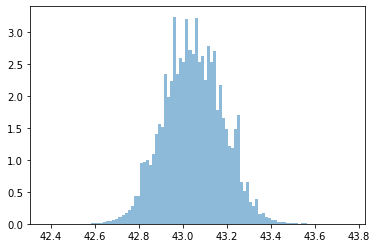

In [10]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(800*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [32]:
0.00980*c*1e-3/44.9, 0.00980*c*1e-3/45.3

(65.47884187082406, 64.90066225165563)

In [23]:
np.shape(flat['T'][:,25*1000:])

(1250000,)

In [39]:
np.shape(np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]))

(7, 900000)

In [11]:
import corner

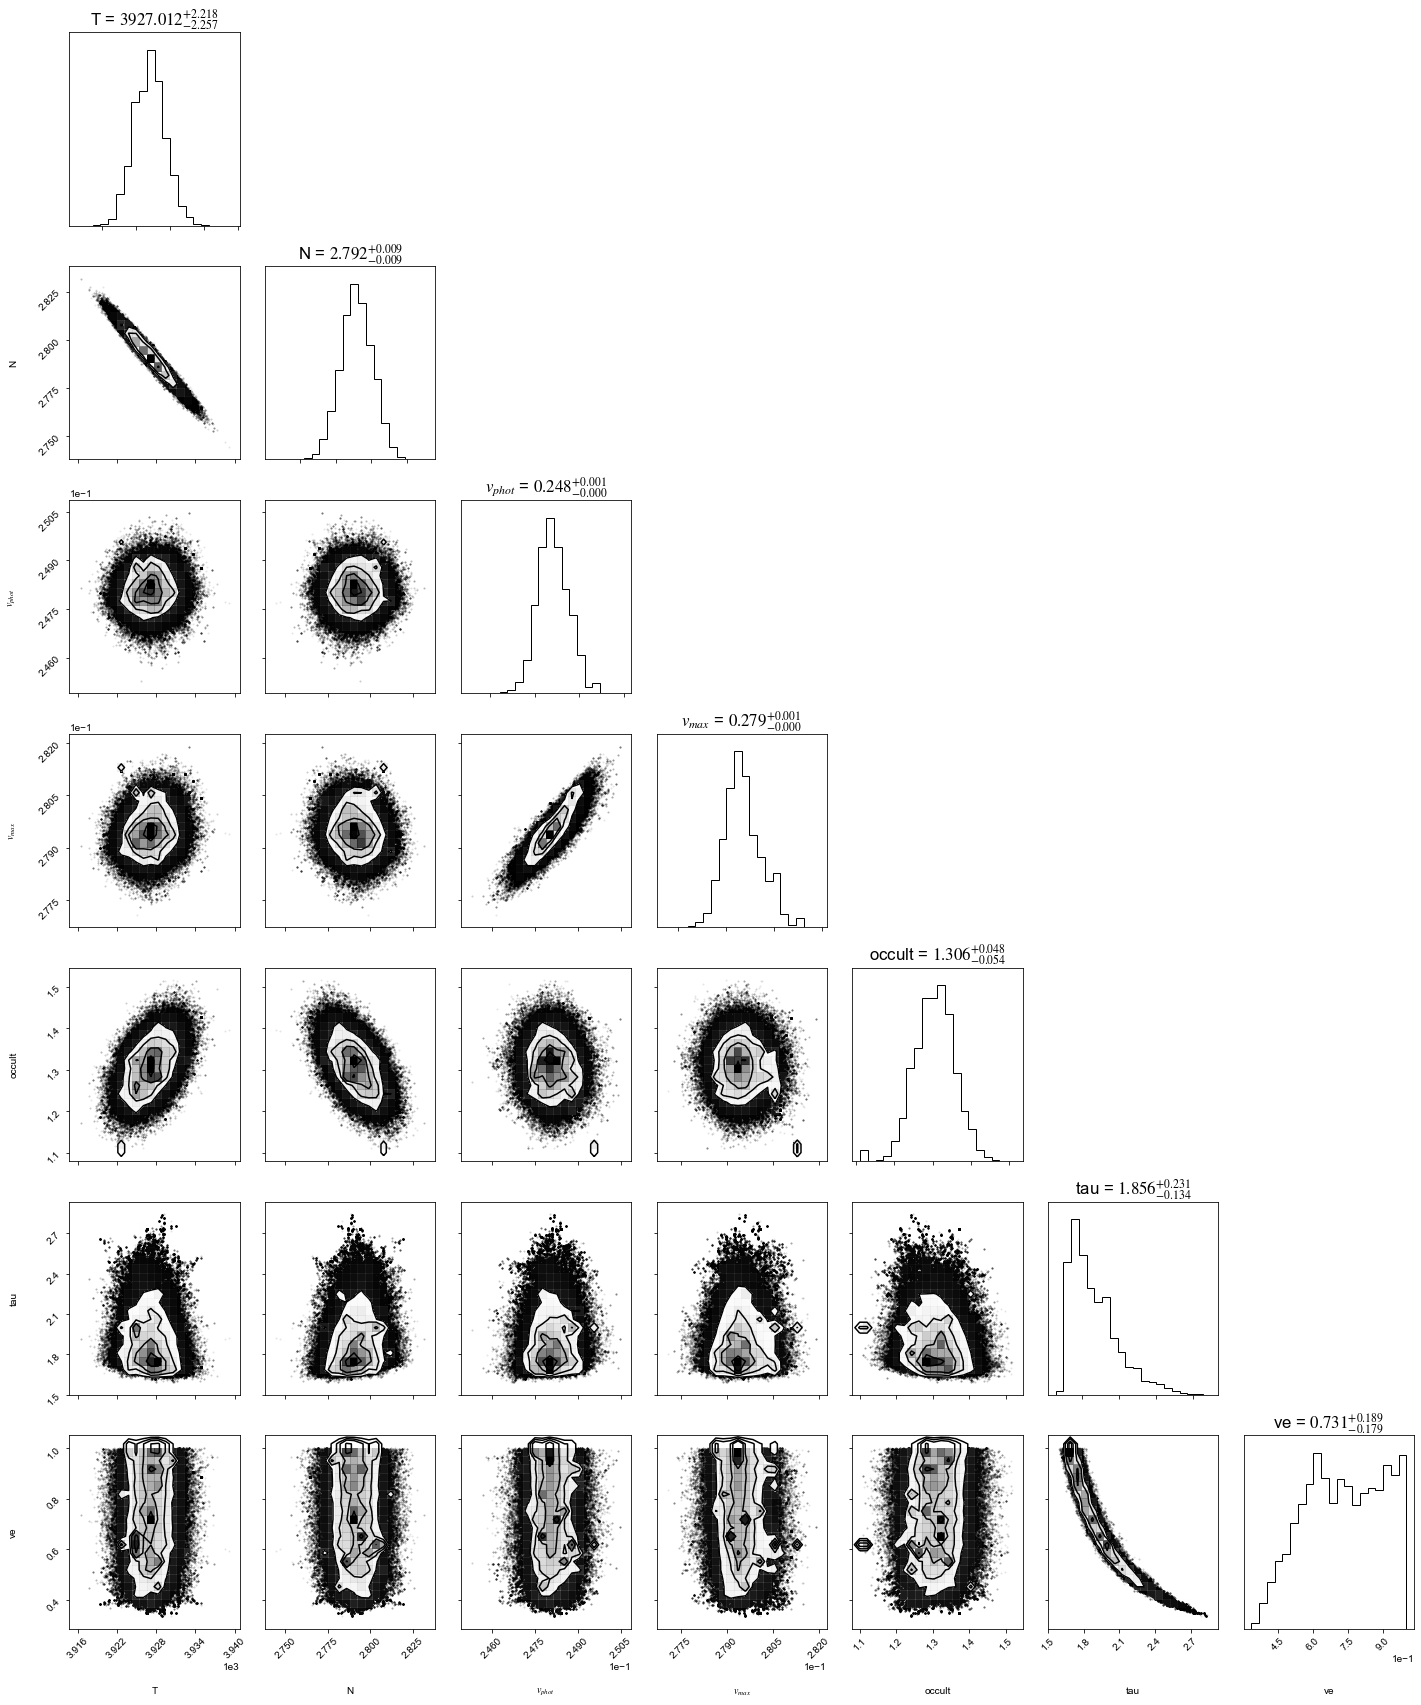

In [12]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'][25*1000:], flat['N'][25*1000:]*1e29, flat['vphot'][25*1000:], flat['vmax'][25*1000:], flat['occult'][25*1000:], flat['tau'][25*1000:], flat['ve'][25*1000:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB2_covariance_large_filtered_2.png', dpi=300)

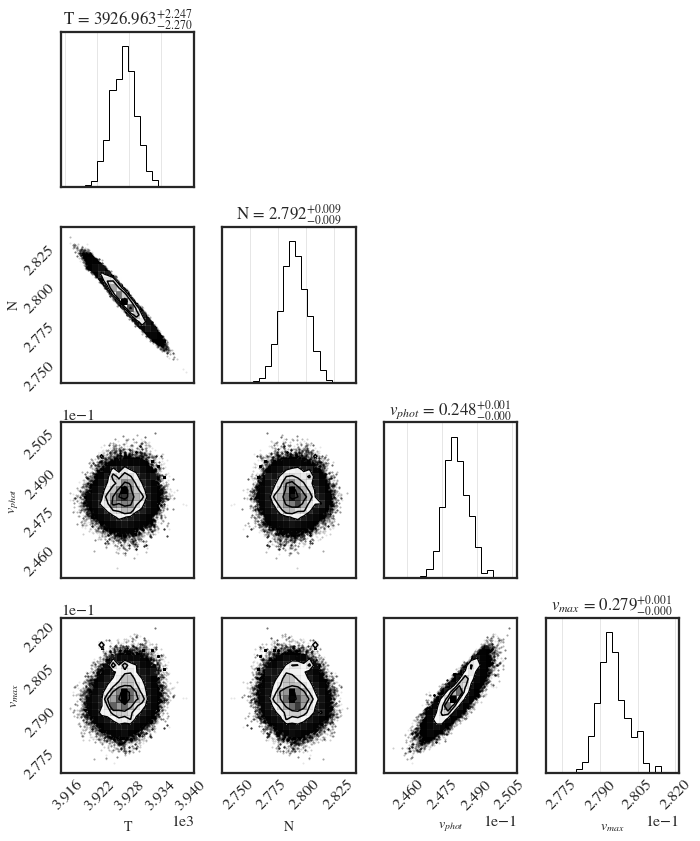

In [13]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

plt.savefig('Pictures/OB2_covariance_small_2.png', dpi=300)